In [9]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from nuflux.detgeo import SimulateDecays, SimulateDetector, check_mem, plot, phi_distribution, event_timing, energies, plot_det, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
cc = SimulateDecays('mutristan l', N_evals = 1e5)

Simulation: μTRISTAN (L) parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.67 s


In [41]:
Lss = 30
geom = "det_v2"
collision = 'mu+mu+'
sims = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)
Lss = 300
sims2 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: μTRISTAN (L) (μ+μ+) at L = 30.00 m with Det v2 as a detector
Total Count: 3.82e+11 events; took 15.7 s
Simulation: μTRISTAN (L) (μ+μ+) at L = 300.00 m with Det v2 as a detector
Total Count: 7.76e+11 events; took 13.8 s


In [20]:
cc = SimulateDecays('mucol s2', N_evals = 1e5)

Simulation: MuCoL (s2) parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.8 s


In [68]:
Lss = 65
collision = 'mu+mu-'
sims3 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 1, show_time = 0, collision = collision)
Lss = 400

Simulation: MuCoL (s2) (μ+μ-) at L = 65.00 m with Det v2 as a detector
Total Count: 1.71e+11 events; took 1.72 s
+----------------+------------+-----------------+------------+-----------------+--------------+
| Detector Parts | ν_e events | anti ν_e events | ν_μ events | anti ν_μ events | Total Events |
+----------------+------------+-----------------+------------+-----------------+--------------+
| muon_detector  | 2.720e+10  |    1.409e+10    | 3.214e+10  |    1.671e+10    |  9.014e+10   |
|    solenoid    | 1.247e+09  |    6.461e+08    | 1.503e+09  |    7.814e+08    |  4.177e+09   |
|      hcal      | 1.521e+10  |    7.878e+09    | 1.767e+10  |    9.182e+09    |  4.994e+10   |
|      ecal      | 3.128e+09  |    1.620e+09    | 3.699e+09  |    1.924e+09    |  1.037e+10   |
|    nozzles     | 4.306e+09  |    2.223e+09    | 6.673e+09  |    3.484e+09    |  1.669e+10   |
|     TOTAL      | 5.109e+10  |    2.646e+10    | 6.169e+10  |    3.208e+10    |  1.713e+11   |
+----------------+-----

In [22]:
Lss = 400
collision = 'mu+mu-'
sims4 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: MuCoL (s2) (μ+μ-) at L = 400.00 m with Det v2 as a detector
Total Count: 5.33e+11 events; took 1.33 s


In [10]:
#plot(sims, fs = (10,6), orientation = 'z-y')

In [39]:
#phi_distribution(sims, nbins = 50)

<ipython-input-42-0aa7d1ed5163>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


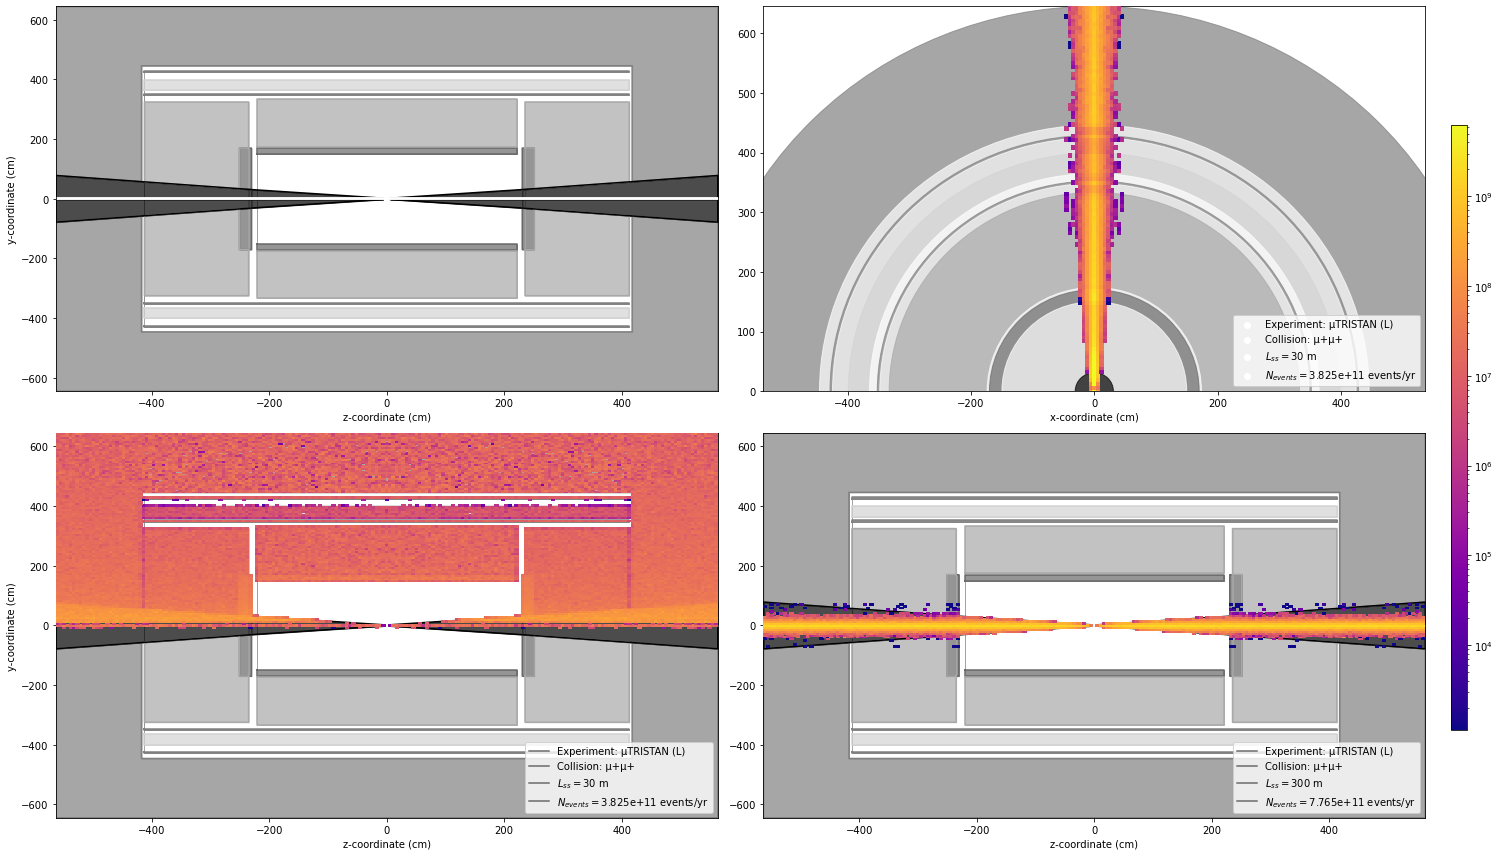

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (21.05,12))
x, y, z, w, _, _ = get_data(sims)
_, y2, z2, w2, _, _ = get_data(sims2)

h1 = np.histogram2d(x, y, weights = w, bins = 200)
h2 = np.histogram2d(z, y, weights = w, bins = 200)
h3 = np.histogram2d(z2, y2, weights = w2, bins = 200)

vmin = min(np.min(h1[0][h1[0] > 1e3]), np.min(h2[0][h2[0] > 1e3]), np.min(h3[0][h3[0] > 1e3]))
vmax = max(h1[0].max(), h2[0].max(), h3[0].max())

plot_det('det_v2', axs[0,0], xl  = True, orientation = 'z-y')
h = plot(sims, orientation = 'x-y', ax = axs[0,1], title = False, xl = True, yl = False, vmin = vmin, vmax = vmax, h = True, cmap = 'plasma')
plot(sims, ax = axs[1,0], title = False, vmin = vmin, vmax = vmax, cmap = 'plasma')
plot(sims2, ax = axs[1,1], title = False, yl = False, vmin = vmin, vmax = vmax, cmap = 'plasma')

cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])  # Position: [left, bottom, width, height]
fig.colorbar(h[3], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.95, 1]) 
plt.savefig("plots_Luc/paper/events6.jpg", bbox_inches = 'tight', dpi = 300)

In [62]:
cc = SimulateDecays('mokhov', N_evals = 1e5)
Lss = 50
collision = 'mu+mu-'
sims5 = SimulateDetector(cc, geom = geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: Mohkov et al. (Fermilab) parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.73 s
Simulation: Mohkov et al. (Fermilab) (μ+μ-) at L = 50.00 m with Det v2 as a detector
Total Count: 8.86e+10 events; took 1.46 s


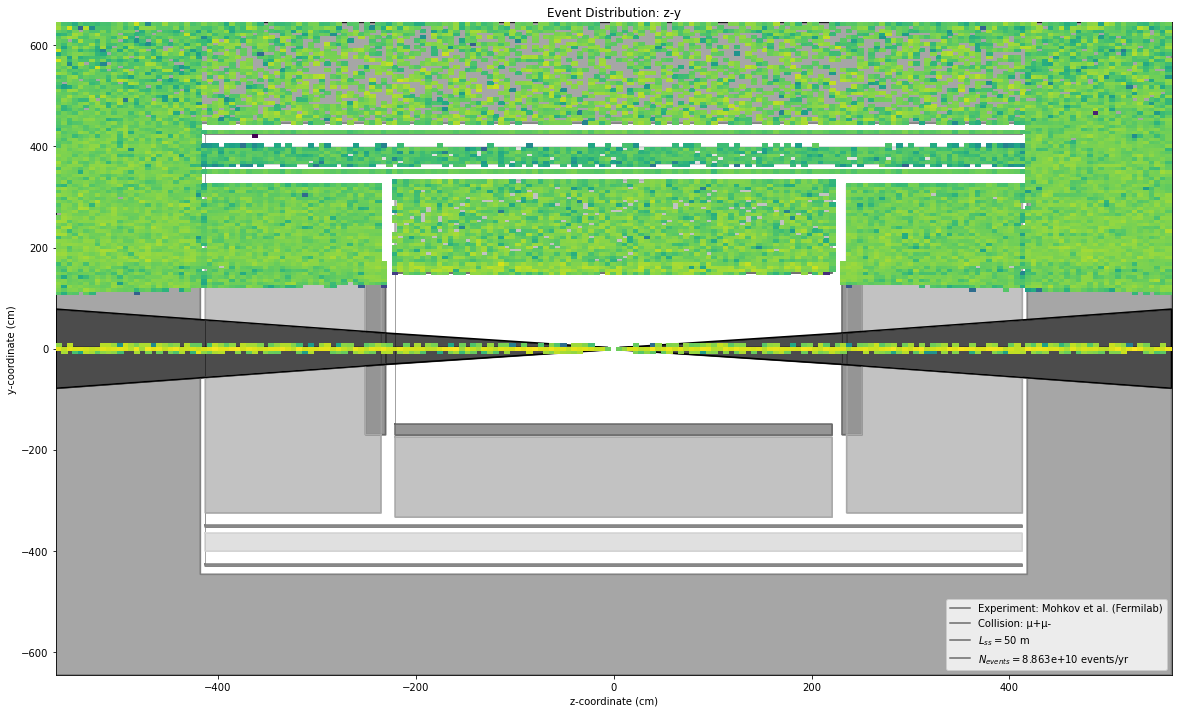

In [63]:
plot(sims5, h = False)

In [99]:
Lss = 200
collision = 'mu+mu-'
sims6 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: MuCoL (s2) (μ+μ-) at L = 200.00 m with Det v2 as a detector
Total Count: 1.96e+11 events; took 1.19 s


In [100]:
Lss = 400
collision = 'mu+mu-'
sims7 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: MuCoL (s2) (μ+μ-) at L = 400.00 m with Det v2 as a detector
Total Count: 5.33e+11 events; took 1.34 s


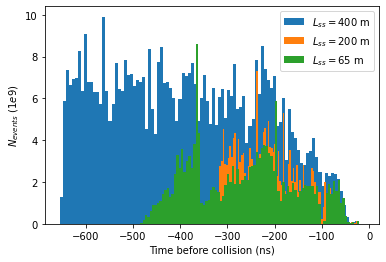

In [116]:
event_timing(sims7, fs=None, title = False)
event_timing(sims6, fs = None, title = 0)
event_timing(sims5, fs = None, legend =True, title = 0,savefig ='plots_Luc/paper/times.jpg')

In [12]:
#case study: mohkov parameters, neutrino events per bunch crossing.
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from nuflux.detgeo import SimulateDecays, SimulateDetector, check_mem, plot, phi_distribution, event_timing
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
cc = SimulateDecays('mohkov', N_evals = 1e5)
Lss = 50
geom = "det_v2"
collision = 'mu+mu-'
sims = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 1, show_time = 0, collision = collision)

Simulation: Mohkov Fermilab parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.52 s
Simulation: Mohkov Fermilab (μ+μ-) at L = 50.00 m with Det v2 as a detector
Total Count: 7.31e+03 events; took 2.52 s
+----------------+------------+-----------------+------------+-----------------+--------------+
| Detector Parts | ν_e events | anti ν_e events | ν_μ events | anti ν_μ events | Total Events |
+----------------+------------+-----------------+------------+-----------------+--------------+
| muon_detector  | 1.148e+03  |    5.839e+02    | 1.274e+03  |    6.454e+02    |  3.651e+03   |
|    solenoid    | 6.475e+01  |    3.292e+01    | 7.234e+01  |    3.662e+01    |  2.066e+02   |
|      hcal      | 5.587e+02  |    2.841e+02    | 6.346e+02  |    3.215e+02    |  1.799e+03   |
|      ecal      | 1.015e+02  |    5.165e+01    | 1.134e+02  |    5.752e+01    |  3.242e+02   |
|    nozzles     | 4.286e+02  |    2.181e+02    | 4.559e+02  |    2.312e+02    |  1.334e+03   |
|     

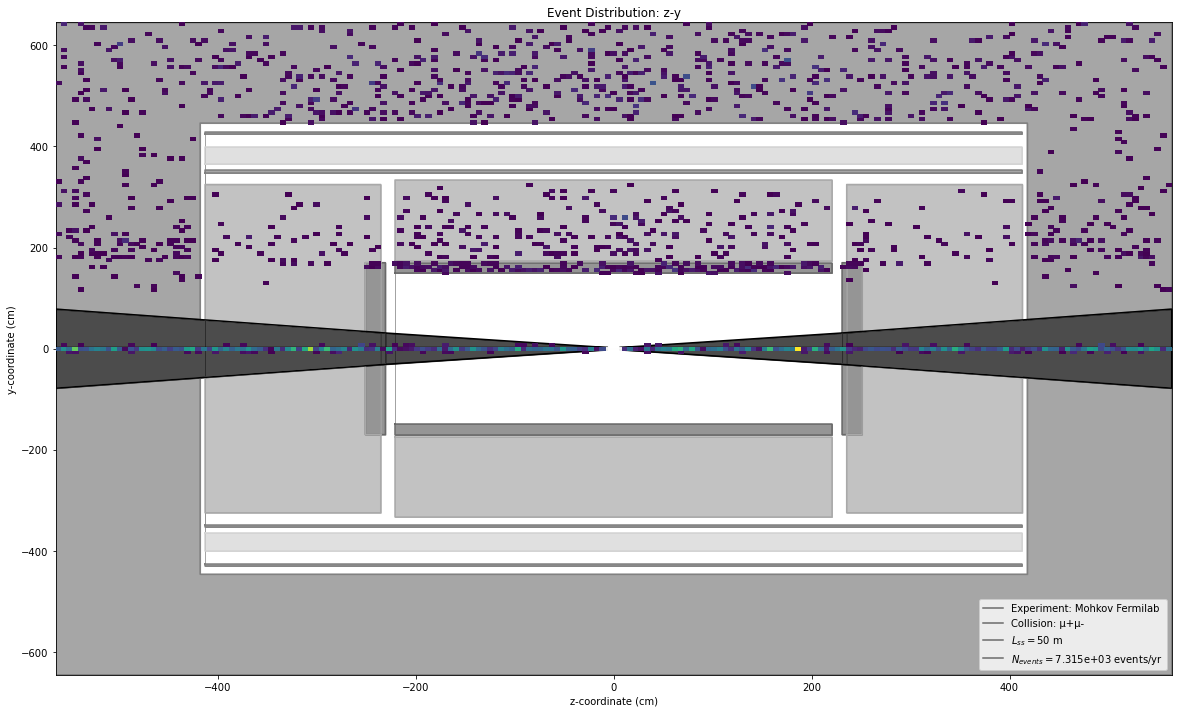

In [39]:
plot(sims)

In [4]:
#so about 7500 events; frep is 15 Hz, so..
print(f"Neutrino Events per bunch crossing (Mohkov): {sims[0].tc/15:.3e}")

Neutrino Events per bunch crossing (Mohkov): 4.966e+02


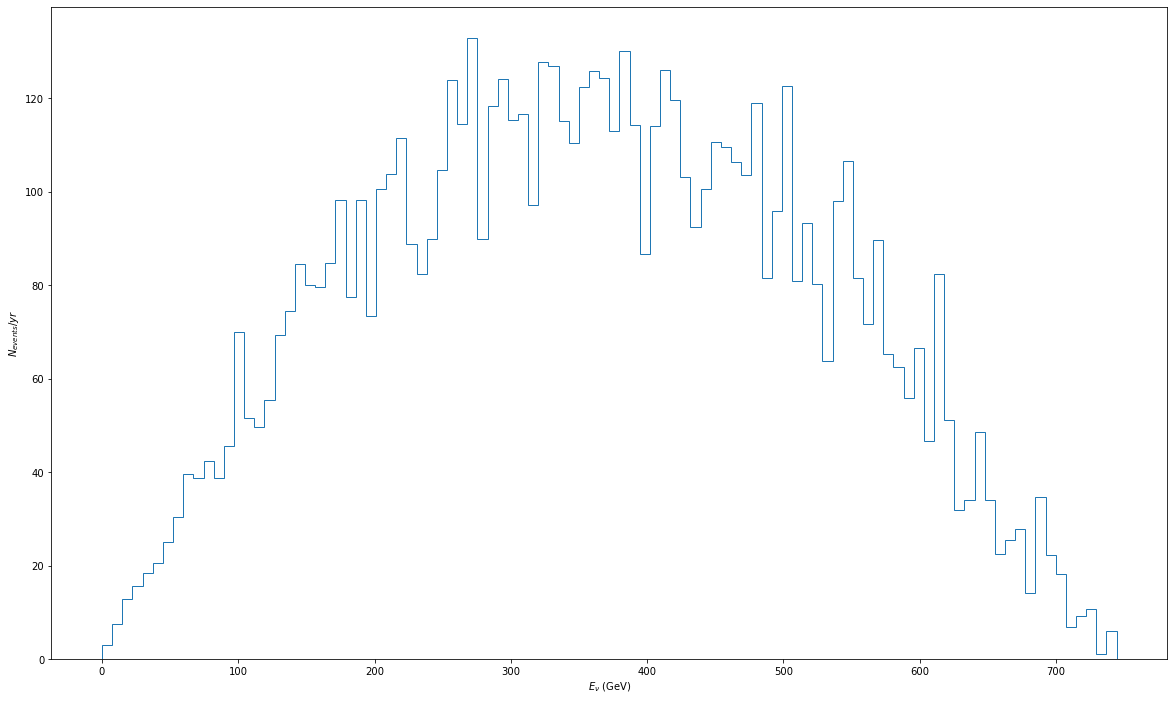

In [25]:
E,w = energies(sims, give_data = True)

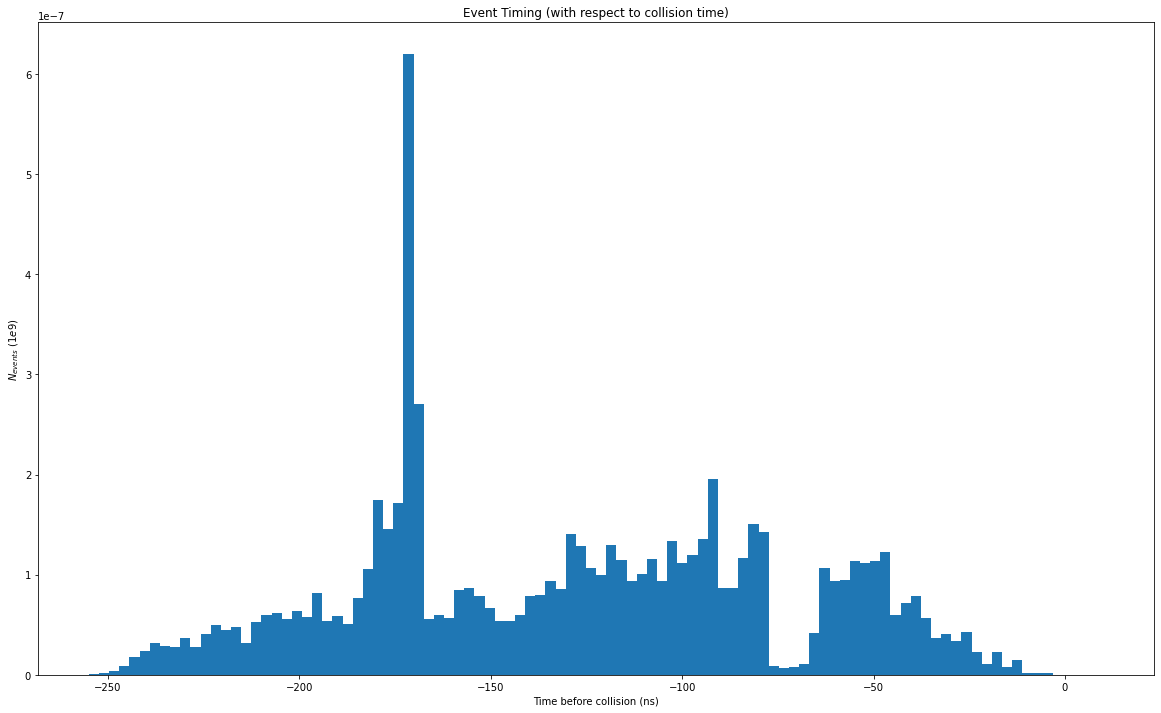

In [40]:
event_timing(sims)

In [31]:
np.sum(E*w)/np.sum(w) * 1e-3 *sims[0].tc /15

178.95823744328416

In [33]:
1e10 / (365.25 * 24* 3600 * 0.7) / 4e6

0.00011317174219296054

In [36]:
1e10/(1.2e7)/5

166.66666666666669

In [54]:
check_mem()

Filename: /n/home06/lbojorquezlopez/BIN_MC/nuflux/detgeo.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     1                                         import sys, os
     2                                         cfp = os.path.dirname(os.path.abspath(__file__))
     3                                         td = os.path.join(cfp,'detector_geometries')
     4                                         sys.path.append(td)
     5                                         cfp = os.path.dirname(os.path.abspath(__file__))
     6                                         sys.path.append(cfp)
     7                                         
     8                                         import copy, gc, importlib, time
     9                                         import numpy as np
    10                                         import matplotlib.pyplot as plt
    11                                         from numba import njit, jit
    12                                         f